In [290]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages

In [291]:
def sigmoid(x, a, b, c, d):
    return a / (1.0 + np.exp(-c * (x - d))) + b

In [292]:
drug = 'berzosertib'
cell_line = 'oc3'
replicate = 'r2'


# Initialize plate naming
if drug == 'pf' or drug == 'berzosertib' or drug == 'palbociclib' or drug == 'cvt':
    plate_name = cell_line+'-cbpp'
elif drug == 'cisplatin' or drug == 'olaparib' or drug == 'adavosertib' or drug == 'ro':
    plate_name = cell_line+'-coar'


# File handling
csv_path = r'/Volumes/HSIT-Stallaert-Lab/data_analysis/Tyler/hgsc/data/hgsc-full-r2/'+plate_name+'/'+drug+'.csv'
save_dir = os.path.join(r'/Volumes/HSIT-Stallaert-Lab/data_analysis/Tyler/hgsc/data/figures',cell_line)
if not os.path.isdir(save_dir): os.mkdir(save_dir)

drug_dir = os.path.join(save_dir,drug)
if not os.path.isdir(drug_dir): os.mkdir(drug_dir)

df = pd.read_csv(csv_path)


# Setup concentrations
if 'cbpp' in csv_path: concentrations = [0, 0.0005, 0.001, 0.01, 0.1, 0.5, 1, 5]
elif 'coar' in csv_path: concentrations = [0,.001,.01,.1,.5,1,5,10]

In [294]:
# make EdU graph
to_save = True


data = df['EdU-mean']

rep_data = []

for x in np.unique(df['condition']):
    sub_df = df[df['condition'] == x]
    sub_data = list(sub_df['EdU-mean'])

    try:
        l = random.sample(sub_data,100)
        rep_data = rep_data+l
    except:
        rep_data = rep_data + sub_data

thresh = 7
thresh_list = [thresh for x in np.unique(df['condition'])]
#thresh_list[0] = 8.5
#thresh_list[1] = 8
#thresh_list[2] = 8.2
#thresh_list[3] = 8.3
#thresh_list[4] = 8.3
# thresh_list[5] = 8.5
#thresh_list[6] = 8.5
#thresh_list[7] = 8.3


print(f'Theshold: {thresh}')

pdf_name = '_'.join([datetime.today().strftime('%Y-%m-%d'),replicate,drug,'EdU-histograms.pdf'])
pdf_path = os.path.join(drug_dir,pdf_name)



with PdfPages(pdf_path) as pdf:                 # COMMENT/UNCOMMENT FOR SAVING
#if 1+1:

    fig,ax = plt.subplots(1,1)
    ax = sns.histplot(np.log(data),bins=50)

    ax.axvline(x=thresh)
    ax.text(x=thresh,y=ax.get_ylim()[-1]/2,s=f'          Treshold: {thresh}')
    plt.title('Aggregated EdU Distribution')      

    if to_save:
        pdf.savefig()                               
        plt.close()                                 




    perc_vals = []

    for i,x in enumerate(np.unique(df['condition'])):

        sub_df = df[df['condition'] == x]
        sub_data = sub_df['EdU-mean']

        perc_pos = len([x for x in sub_data if x>np.exp(thresh_list[i])])/len(sub_data)

        print(f'Condition {x}... %Pos: {round(perc_pos*100,2)}')

        perc_vals.append(perc_pos)

        fig,ax = plt.subplots(figsize=(6,6))
        sns.histplot(np.log(sub_data),bins=50,ax=ax)
        ax.axvline(x=thresh_list[i],color='red',linestyle='--')

        ax.text(sum(ax.get_xlim())/2,
                sum(ax.get_ylim())/2,
                s=f'% 2N: {round(perc_pos*100,2)}',
                ha='left',va='top')
        plt.title(f'Condition {x}: EdU Distribution')
        
        if to_save:
            pdf.savefig()                               # COMMENT/UNCOMMENT FOR SAVING
            plt.close()                                 # COMMENT/UNCOMMENT FOR SAVING

conditions_to_exclude = []
fin_concentrations = [x for i,x in enumerate(concentrations) if i not in conditions_to_exclude]
fin_percs = [x for i,x in enumerate(perc_vals) if i not in conditions_to_exclude]

popt,pcov = curve_fit(sigmoid,
                      fin_concentrations,
                      fin_percs,
                      maxfev=100000)

x_fit = np.linspace(min(concentrations),max(concentrations),1000)
y_fit = sigmoid(x_fit,*popt)

IC50_y = ((np.max(y_fit)-np.min(y_fit))/2)+np.min(y_fit)
IC50 = x_fit[list(y_fit).index(y_fit[np.abs(y_fit - IC50_y).argmin()])]

fit_for_y = sigmoid(fin_concentrations,*popt)
r_squared = r2_score(fin_percs,fit_for_y)
print(r_squared)


pdf_name = '_'.join([datetime.today().strftime('%Y-%m-%d'),replicate,drug,'EdU-annotated-drc.pdf'])
pdf_path = os.path.join(drug_dir,pdf_name)


#if 1:
with PdfPages(pdf_path) as pdf:
    l = plt.figure()
    #plt.scatter(fin_concentrations,fin_percs,label='Data',color='red')
    plt.scatter(concentrations,perc_vals,label='Data',color='red')
    plt.plot(x_fit,y_fit,label='Fitted Curve', color='blue')
    plt.xscale('log')
    plt.xlabel('Drug Concentrations')
    plt.ylabel('% Positive')
    plt.legend()

    plt.text(x=.5,y=np.average(perc_vals),s=f'R-Squared: {round(r_squared,2)} \n IC-50: {round(IC50,2)}')
    plt.title(label='Concentration v. Proportion EdU(+)')
    plt.axvline(x=IC50,color='black')

    #plt.show()

    if to_save:
        pdf.savefig()
        plt.close()

Theshold: 7
Condition A... %Pos: 29.29
Condition B... %Pos: 29.95
Condition C... %Pos: 28.1
Condition D... %Pos: 31.03
Condition E... %Pos: 31.45
Condition F... %Pos: 27.87
Condition G... %Pos: 20.27
Condition H... %Pos: 6.34
0.9845598774852062


8
8
0.019095987913914425


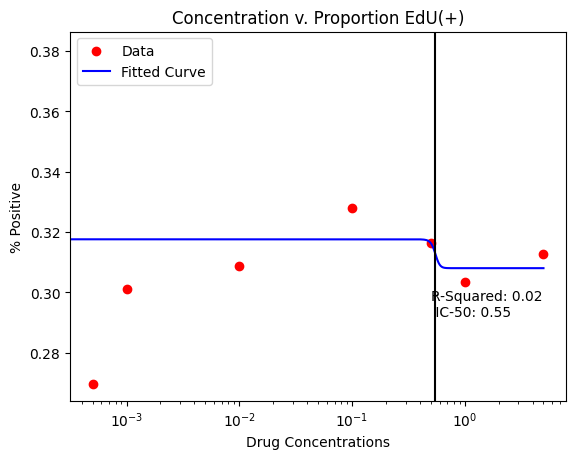

/var/folders/80/0dd29wb12tz3rggyy_q680gr0000gn/T/ipykernel_87145/3707606191.py:26: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages(pdf_path) as pdf:


ValueError: No figure None

In [162]:
fin_concentrations = [x for i,x in enumerate(concentrations)]
print(len(fin_concentrations))
fin_percs = [x for i,x in enumerate(av_set)]
print(len(fin_percs))

popt,pcov = curve_fit(sigmoid,
                      fin_concentrations,
                      fin_percs,
                      maxfev=10000)

x_fit = np.linspace(min(concentrations),max(concentrations),1000)
y_fit = sigmoid(x_fit,*popt)

IC50_y = ((np.max(y_fit)-np.min(y_fit))/2)+np.min(y_fit)
IC50 = x_fit[list(y_fit).index(y_fit[np.abs(y_fit - IC50_y).argmin()])]

fit_for_y = sigmoid(fin_concentrations,*popt)
r_squared = r2_score(fin_percs,fit_for_y)
print(r_squared)


pdf_name = '_'.join([datetime.today().strftime('%Y-%m-%d'),replicate,drug,'EdU-annotated-drc.pdf'])
pdf_path = os.path.join(drug_dir,pdf_name)


with PdfPages(pdf_path) as pdf:
    l = plt.figure()
    plt.scatter(fin_concentrations,fin_percs,label='Data',color='red')
    plt.plot(x_fit,y_fit,label='Fitted Curve', color='blue')
    plt.xscale('log')
    plt.xlabel('Drug Concentrations')
    plt.ylabel('% Positive')
    plt.legend()

    plt.text(x=.5,y=np.average(perc_vals),s=f'R-Squared: {round(r_squared,2)} \n IC-50: {round(IC50,2)}')
    plt.title(label='Concentration v. Proportion EdU(+)')
    plt.axvline(x=IC50,color='black')

    plt.show()

    pdf.savefig()
    plt.close()

In [187]:
data[data > np.percentile(data,1)]

0          511114.0
1          642247.0
3          388560.0
7          747057.0
8          426337.0
            ...    
177746     535942.0
177747    1303822.0
177748    5297349.0
177749    4685515.0
177750    2009755.0
Length: 175973, dtype: float64

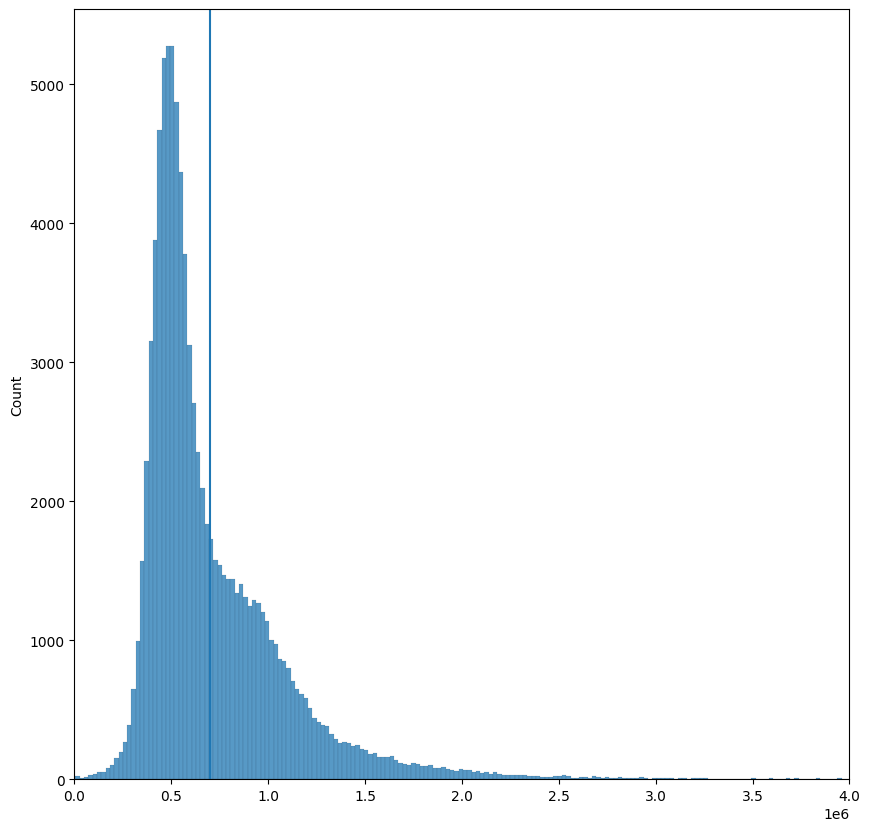

In [238]:
hp, vp = plt.subplots(1,figsize=(10,10))

data = df['DAPI-mean']*df['area']
cdf = df[df['DAPI-mean']*df['area'] > np.percentile(data,.1)]
cdf = cdf[cdf['DAPI-mean']*cdf['area'] < np.percentile(data,99)]
cdata = cdf['DAPI-mean']*cdf['area']

sns.histplot( data , bins = 1000)
vp.set_xlim((0,4000000))

thresh = .7*pow(10,6)
vp.axvline(x=thresh)

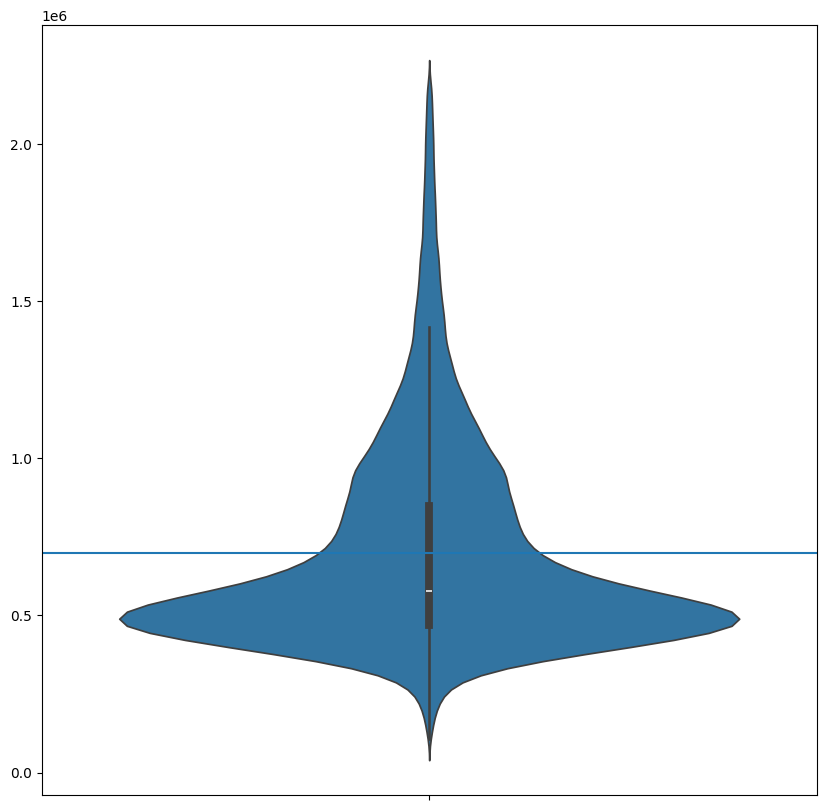

In [239]:
hp, vp = plt.subplots(1,figsize=(10,10))

vp = sns.violinplot(cdata)
vp.axhline(y=thresh)

In [74]:
# make int-DNA graph
to_save = True


data = df['DAPI-mean']*df['area']

low_lim = 1
up_lim = 99

rep_data = [1]

for x in np.unique(df['condition']):
    sub_df = df[df['condition'] == x]
    sub_data = list(sub_df['DAPI-mean']*sub_df['area'])

    try:
        l = random.sample(sub_data,100)
        rep_data = rep_data+l
    except:
        l = [x for x in sub_data]
        rep_data = rep_data+l

cleaned_data = [x for x in rep_data if x>np.percentile(data,low_lim) and x<np.percentile(data,up_lim)]

thresh = .75 * (pow(10,6))
#thresh_list = [thresh for x in np.unique(df['condition'])]
thresh_list = np.exp([13.5,  13.5, 13.45,  13.45, 13.5, 13.5 , 13.45, 13.5])
#thresh_list = [x*pow(10,6) for x in thresh_list]
#print(f'Theshold: {thresh}')

pdf_name = '_'.join([datetime.today().strftime('%Y-%m-%d'),replicate,drug,'DNA-histograms.pdf'])
pdf_path = os.path.join(drug_dir,pdf_name)

with PdfPages(pdf_path) as pdf:                 # COMMENT/UNCOMMENT FOR SAVING
#if 1+1:

    fig,ax = plt.subplots(1,1)
    ax = sns.histplot(cleaned_data,bins=50)

    ax.axvline(x=thresh)
    ax.text(x=thresh,y=ax.get_ylim()[-1]/2,s=f'          Treshold: {thresh}')
    plt.title('Aggregated Integrated DNA')      

    if to_save:
        pdf.savefig()                               
        plt.close()                                 

    perc_vals = []

    for i,x in enumerate(np.unique(df['condition'])):

        sub_df = df[df['condition'] == x]
        sub_data = sub_df['DAPI-mean']*sub_df['area']

        cleaned_data = sub_data[sub_data>np.percentile(sub_data,1)]
        cleaned_data = cleaned_data[cleaned_data<np.percentile(sub_data,99)]

        perc_2n = len(cleaned_data[cleaned_data<thresh_list[i]])/len(cleaned_data)
        perc_4n = len(cleaned_data[cleaned_data>thresh_list[i]])/len(cleaned_data)

        print(f'Condition {x}... %2n: {round(perc_2n*100,2)}')
        perc_vals.append(perc_2n)

        fig,ax = plt.subplots(figsize=(6,6))
        sns.histplot(np.log(cleaned_data),bins=50,ax=ax)
        #ax.axvline(x=thresh_list[i],color='red',linestyle='--')

        ax.text(sum(ax.get_xlim())/2,
                sum(ax.get_ylim())/2,
                s=f'% 2N: {round(perc_2n*100,2)}',
                ha='left',va='top')
        plt.title(f'Condition {x}: Integrated DNA')
        
        if to_save:
            pdf.savefig()                               # COMMENT/UNCOMMENT FOR SAVING
            plt.close()                                 # COMMENT/UNCOMMENT FOR SAVING


conditions_to_exclude = [1,3]



fin_concentrations = [x for i,x in enumerate(concentrations) if i not in conditions_to_exclude]
fin_percs = [x for i,x in enumerate(perc_vals) if i not in conditions_to_exclude]
fin_percs[0] = .6   # control average across plate

popt,pcov = curve_fit(sigmoid,fin_concentrations,fin_percs)
x_fit = np.linspace(min(fin_concentrations),max(fin_concentrations),1000)
y_fit = sigmoid(x_fit,*popt)

IC50_y = ((np.max(y_fit)-np.min(y_fit))/2)+np.min(y_fit)
IC50 = x_fit[list(y_fit).index(y_fit[np.abs(y_fit - IC50_y).argmin()])]

fit_for_y = sigmoid(fin_concentrations,*popt)
r_squared = r2_score(fin_percs,fit_for_y)
print(r_squared)


pdf_name = '_'.join([datetime.today().strftime('%Y-%m-%d'),replicate,drug,'DNA-annotated-drc.pdf'])
pdf_path = os.path.join(drug_dir,pdf_name)


#if 1:
with PdfPages(pdf_path) as pdf:
    l = plt.figure()
    plt.scatter(fin_concentrations,fin_percs,label='Data',color='red')
    plt.plot(x_fit,y_fit,label='Fitted Curve', color='blue')
    plt.xscale('log')
    plt.xlabel('Drug Concentrations')
    plt.ylabel('% 2N DNA Content')
    plt.legend()

    plt.text(x=.5,y=np.average(fin_percs),s=f'R-Squared: {round(r_squared,2)} \n IC-50: {round(IC50,2)}')
    plt.title(label='Concentration v. Proportion 2n DNA Content')
    plt.axvline(x=IC50,color='black')

    if to_save:
        pdf.savefig()
        plt.close()

Condition A... %2n: 64.87
Condition B... %2n: 54.07
Condition C... %2n: 60.58
Condition D... %2n: 57.43
Condition E... %2n: 60.46
Condition F... %2n: 66.83
Condition G... %2n: 67.7
Condition H... %2n: 68.09
0.9969347056349808


Theshold: 8.7
Condition A... %Pos: 11.87
Condition B... %Pos: 19.39
Condition C... %Pos: 20.0
Condition D... %Pos: 9.69
Condition E... %Pos: 15.76
Condition F... %Pos: 22.66
Condition G... %Pos: 12.01
Condition H... %Pos: 16.02


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

In [98]:
full_set = full_set + perc_vals

In [135]:
fin_concentrations = [x for i,x in enumerate(concentrations)]
print(len(fin_concentrations))
fin_percs = [x for i,x in enumerate(av_set)]
print(len(fin_percs))

popt,pcov = curve_fit(sigmoid,
                      fin_concentrations,
                      fin_percs,
                      maxfev=10000)

x_fit = np.linspace(min(concentrations),max(concentrations),1000)
y_fit = sigmoid(x_fit,*popt)

IC50_y = ((np.max(y_fit)-np.min(y_fit))/2)+np.min(y_fit)
IC50 = x_fit[list(y_fit).index(y_fit[np.abs(y_fit - IC50_y).argmin()])]

fit_for_y = sigmoid(fin_concentrations,*popt)
r_squared = r2_score(fin_percs,fit_for_y)
print(r_squared)


pdf_name = '_'.join([datetime.today().strftime('%Y-%m-%d'),replicate,drug,'EdU-annotated-drc.pdf'])
pdf_path = os.path.join(drug_dir,pdf_name)


with PdfPages(pdf_path) as pdf:
    l = plt.figure()
    plt.scatter(fin_concentrations,fin_percs,label='Data',color='red')
    plt.plot(x_fit,y_fit,label='Fitted Curve', color='blue')
    plt.xscale('log')
    plt.xlabel('Drug Concentrations')
    plt.ylabel('% Positive')
    plt.legend()

    plt.text(x=.5,y=np.average(perc_vals),s=f'R-Squared: {round(r_squared,2)} \n IC-50: {round(IC50,2)}')
    plt.title(label='Concentration v. Proportion EdU(+)')
    plt.axvline(x=IC50,color='black')

    pdf.savefig()
    plt.close()

8
8
0.8381473230231617


In [136]:
av_set

[0.2059146008808697,
 0.22626920284480426,
 0.23661104710584968,
 0.26061937840665067,
 0.2686977759659243,
 0.28838635831591075,
 0.2941615777361945,
 0.3109520416315778]